# TP06 & TP07 - (A rendre)
**Améliorations du DQN (Double, Dueling, PER)** + **TradingEnv (Gymnasium)**

Notebook pédagogique pour étudiants M2. Exécuter les cellules dans l'ordre. Sections marquées '# TODO' à compléter.


## 0 — Pré-requis et imports
Vérifier l'installation des packages : numpy, pandas, matplotlib, gymnasium, torch, tensorflow (optionnel).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print('numpy', np.__version__, 'pandas', pd.__version__)

numpy 2.1.3 pandas 2.3.3


## TP06 — Améliorations du DQN
Objectifs : Double DQN, Dueling DQN, Prioritized Experience Replay (PER).

### 1) Réseau Q simple — PyTorch
Réseau minimal pour approximation Q.

In [2]:
try:
    import torch, torch.nn as nn, torch.nn.functional as F
    TORCH_AVAILABLE = True
except Exception as e:
    TORCH_AVAILABLE = False
    print('Torch non installé :', e)

if TORCH_AVAILABLE:
    class QNet(nn.Module):
        def __init__(self, state_dim, action_dim):
            super().__init__()
            self.fc1 = nn.Linear(state_dim, 128)
            self.fc2 = nn.Linear(128, 128)
            self.out = nn.Linear(128, action_dim)
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.out(x)

    net = QNet(state_dim=6, action_dim=3)
    sample = torch.randn(2,6)
    print('Output shape (Torch QNet):', net(sample).shape)
else:
    print('PyTorch absent — installez torch pour exécuter cet exemple.')

Output shape (Torch QNet): torch.Size([2, 3])


### 2) Double DQN — calcul de la target (PyTorch)

In [3]:
if TORCH_AVAILABLE:
    import torch
    def ddqn_target(q_online, q_target, next_states, rewards, dones, gamma=0.99):
        with torch.no_grad():
            q_online_next = q_online(next_states)
            next_actions = q_online_next.argmax(dim=1, keepdim=True)
            q_target_next = q_target(next_states).gather(1, next_actions).squeeze(1)
            target = rewards + gamma * q_target_next * (1 - dones)
        return target

    # fake test
    q_online = QNet(6,3); q_target = QNet(6,3)
    ns = torch.randn(4,6); r = torch.randn(4); d = torch.zeros(4)
    print('DDQN target shape:', ddqn_target(q_online, q_target, ns, r, d).shape)
else:
    print('PyTorch required for DDQN example.')

DDQN target shape: torch.Size([4])


### 3) Dueling DQN — architecture (TensorFlow/Keras)

In [16]:
try:
    import tensorflow as tf
    from tensorflow.keras import layers, Model, Input
    TF_AVAILABLE = True
except Exception as e:
    TF_AVAILABLE = False
    print('TensorFlow non disponible:', e)

if TF_AVAILABLE:
    def build_dueling_tf(state_dim, n_actions):
        inputs = Input(shape=(state_dim,))
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.Dense(128, activation='relu')(x)
        value = layers.Dense(1)(x)
        advantage = layers.Dense(n_actions)(x)

        # Combine via Lambda (safe for KerasTensors)
        def dueling_combine(inputs):
            value, advantage = inputs
            mean_adv = tf.reduce_mean(advantage, axis=1, keepdims=True)
            return value + (advantage - mean_adv)

        q = layers.Lambda(dueling_combine)([value, advantage])
        
        model = Model(inputs=inputs, outputs=q)
        model.compile(optimizer='adam', loss='mse')
        return model

    m = build_dueling_tf(6,3)
    m.summary()
else:
    print('TensorFlow non installé — optionnel pour ce TP.')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │        896 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     16,512 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │        129 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │        387 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 3)         │          0 │ dense_10[0][0],   │
│                     │                   │            │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,924 (70.02 KB)

 Trainable params: 17,924 (70.02 KB)

 Non-trainable params: 0 (0.00 B)

### 4) Prioritized Experience Replay (naïf)

In [6]:
import numpy as np
class SimplePrioritizedReplay:
    def __init__(self, capacity=10000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = []
    def push(self, transition, priority=None):
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(priority if priority is not None else max(self.priorities, default=1.0))
        else:
            idx = len(self.buffer) % self.capacity
            self.buffer[idx] = transition
            self.priorities[idx] = priority if priority is not None else max(self.priorities, default=1.0)
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            return [], [], []
        probs = np.array(self.priorities) ** self.alpha
        probs = probs / probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights = weights / (weights.max() + 1e-9)
        return samples, indices, weights
    def update_priorities(self, indices, priorities):
        for idx, p in zip(indices, priorities):
            self.priorities[idx] = p

# smoke test
replay = SimplePrioritizedReplay(100)
for i in range(20):
    replay.push(('s'+str(i),'a',i,'s2',False))
s, idx, w = replay.sample(5)
print('Sampled', len(s))

Sampled 5


### 5) Visualisation comparative — Matplotlib

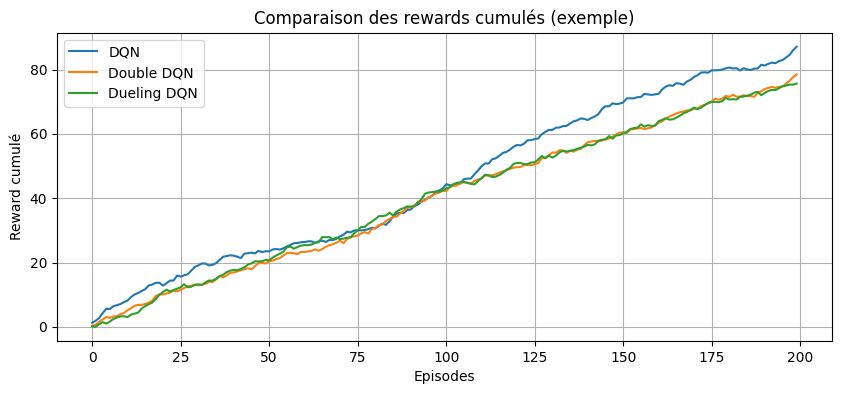

In [7]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
r_dqn = np.cumsum(np.random.randn(200) * 0.5 + 0.4)
r_double = np.cumsum(np.random.randn(200) * 0.45 + 0.45)
r_dueling = np.cumsum(np.random.randn(200) * 0.48 + 0.43)
plt.figure(figsize=(10,4))
plt.plot(r_dqn, label='DQN')
plt.plot(r_double, label='Double DQN')
plt.plot(r_dueling, label='Dueling DQN')
plt.title('Comparaison des rewards cumulés (exemple)')
plt.xlabel('Episodes'); plt.ylabel('Reward cumulé')
plt.legend(); plt.grid(True); plt.show()

### TD TP06 — Énoncés & Corrigés synthétiques
1) Implémenter la target Double DQN. 
2) Ajouter Dueling. 
3) Intégrer PER.

Indices : utiliser q_online.argmax pour la selection et q_target.gather pour l'évaluation. Dueling: Q = V + (A - mean(A)). PER: p_i = |δ_i|^α, w_i = (1/(N*P(i)))^β.

#### - Double DQN

In [8]:
# importation des packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random

In [9]:
class QNetworkDoubleDQN(nn.Module):
    """
    Réseau Q pour Double DQN
    Double DQN résout le problème de surestimation des Q-values en :
    - Utilisant le réseau online pour SÉLECTIONNER l'action
    - Utilisant le réseau target pour ÉVALUER cette action
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


def compute_double_dqn_loss(q_online, q_target, batch, gamma=0.99, device='cpu'):
    """
    Calcule la loss Double DQN
    
    Principe :
    1. Online network sélectionne la meilleure action : a* = argmax Q_online(s', a)
    2. Target network évalue cette action : Q_target(s', a*)
    3. Target = r + γ * Q_target(s', a*)
    
    Args:
        q_online: réseau pour sélectionner les actions
        q_target: réseau pour évaluer les actions
        batch: tuple (states, actions, rewards, next_states, dones)
        gamma: facteur de discount
        device: 'cpu' ou 'cuda'
    
    Returns:
        loss: MSE entre Q_online(s,a) et target
    """
    states, actions, rewards, next_states, dones = batch
    
    # Convertir en tensors
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)
    
    # Q-values actuelles : Q(s, a)
    current_q_values = q_online(states).gather(1, actions).squeeze(1)
    
    with torch.no_grad():
        # ÉTAPE 1 : Online network sélectionne les meilleures actions
        # a* = argmax_a' Q_online(s', a')
        next_actions = q_online(next_states).argmax(dim=1, keepdim=True)
        
        # ÉTAPE 2 : Target network évalue ces actions
        # Q_target(s', a*)
        next_q_values = q_target(next_states).gather(1, next_actions).squeeze(1)
        
        # ÉTAPE 3 : Calculer la target
        # y = r + γ * Q_target(s', a*) * (1 - done)
        target_q_values = rewards + gamma * next_q_values * (1 - dones)
    
    # Loss MSE
    loss = F.mse_loss(current_q_values, target_q_values)
    
    return loss

- <b> Interprétation: </b> 
Fonction PyTorch calcule la valeur cible (target) pour la mise à jour de la fonction Q, en utilisant la méthode Double DQN. 
Par analyse le DDQN résout le problème de la surestimation des Q-values, inhérent au DQN classique. Il utilise le réseau online pour sélectionner l'action future $a^{*}$ ($\arg\max_a Q_{online}(s', a)$) et le réseau target pour évaluer cette action ($Q_{target}(s', a^{*})$). Cette séparation du rôle de sélection et d'évaluation réduit le biais optimiste.
- <b> En conclusion: </b>
Ce bloc de codes est fondamental pour la stabilité de l'apprentissage. Il garantit que l'agent ne se fie pas à des estimations de valeur trop optimistes, menant à une convergence plus fiable

#### - DUELING DQN

In [10]:
class DuelingQNetwork(nn.Module):
    """
    Architecture Dueling DQN
    
    Principe :
    Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
    
    Où :
    - V(s) : Value function, valeur de l'état (indépendant de l'action)
    - A(s,a) : Advantage function, avantage de chaque action
    - La soustraction de la moyenne stabilise l'apprentissage
    
    Avantage : Apprend séparément :
    1. Si un état est bon (V)
    2. Quelle action est meilleure dans cet état (A)
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        
        # Feature extractor commun
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Stream Value : estime V(s)
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Une seule valeur pour l'état
        )
        
        # Stream Advantage : estime A(s,a) pour chaque action
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)  # Une valeur par action
        )
    
    def forward(self, x):
        # Extraire les features communes
        features = self.feature(x)
        
        # Calculer V(s)
        value = self.value_stream(features)
        
        # Calculer A(s,a) pour toutes les actions
        advantage = self.advantage_stream(features)
        
        # Combiner : Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
        # La soustraction de la moyenne force l'identifiabilité
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        
        return q_values

- <b> Interprétation: </b> 
Classe PyTorch définissant l'architecture Dueling DQN. Le réseau est divisé en un flux de Valeur ($V(s)$) et un flux d'Avantage ($A(s,a)$), combinés pour former la Q-value.
Par analyse, l'architecture Dueling permet à l'agent d'apprendre séparément la valeur d'un état ($V(s)$) et l'avantage de chaque action ($A(s,a)$). La combinaison finale $Q(s,a) = V(s) + (A(s,a) - \text{mean}(A(s,a')))$ assure l'identifiabilité. Cela est particulièrement efficace dans les environnements où la valeur de l'état est plus importante que l'action (e.g., attendre dans un état favorable).
- <b> En conclusion: </b>
Une amélioration architecturale qui accélère l'apprentissage et améliore la généralisation en se concentrant sur l'estimation de la valeur de l'état.

#### - PRIORITIZED EXPERIENCE REPLAY (PER)

In [11]:
class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay
    
    Principe :
    - Les transitions avec TD-error élevé sont échantillonnées plus souvent
    - Priorité : p_i = |δ_i|^α
    - Importance Sampling weights : w_i = (1 / (N * P(i)))^β
    
    Paramètres :
    - α : contrôle combien de priorité utiliser (0 = uniforme, 1 = full priority)
    - β : correction du biais (start low ~0.4, anneal to 1)
    """
    
    def __init__(self, capacity=100000, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha  # Contrôle l'importance de la priorité
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.pos = 0
    
    def beta_by_frame(self, frame_idx):
        """
        Annealing de β de beta_start à 1.0
        β augmente progressivement pour corriger complètement le biais
        """
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)
    
    def push(self, transition):
        """
        Ajoute une transition avec priorité maximale
        Nouvelle transition = priorité max pour être échantillonnée au moins une fois
        """
        max_priority = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
        
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        """
        Échantillonne un batch selon les priorités
        
        Returns:
            batch: transitions échantillonnées
            indices: indices pour update_priorities
            weights: importance sampling weights pour corriger le biais
        """
        if len(self.buffer) == 0:
            return None, None, None
        
        N = len(self.buffer)
        
        # Calculer les probabilités d'échantillonnage
        # P(i) = p_i^α / Σ p_j^α
        priorities = self.priorities[:N]
        probs = priorities ** self.alpha
        probs = probs / probs.sum() 

        # Échantillonner selon ces probabilités
        replace_flag = N < batch_size
        indices = np.random.choice(N, batch_size, p=probs, replace=replace_flag)
        samples = [self.buffer[idx] for idx in indices]
        
        # Calculer les importance sampling weights
        # w_i = (1 / (N * P(i)))^β
        beta = self.beta_by_frame(self.frame)
        weights = (N * probs[indices]) ** (-beta) 
        
        # Normaliser les weights (max weight = 1)
        weights = weights / weights.max()
        weights = torch.FloatTensor(weights)
        
        self.frame += 1
        
        return samples, indices, weights
    
    def update_priorities(self, indices, priorities):
        """
        Met à jour les priorités après calcul du TD-error
        
        Args:
            indices: indices des transitions
            priorities: nouvelles priorités (généralement |TD-error| + ε)
        """
        for idx, priority in zip(indices, priorities):
            # Ajouter un petit ε pour éviter priorité = 0
            self.priorities[idx] = priority + 1e-5
    
    def __len__(self):
        return len(self.buffer)


def compute_per_loss(q_online, q_target, replay_buffer, batch_size, gamma=0.99, device='cpu'):
    """
    Calcule la loss avec PER
    
    Différence avec DQN standard :
    1. Échantillonnage selon les priorités (pas uniforme)
    2. Utilisation des importance sampling weights
    3. Update des priorités avec les nouveaux TD-errors
    """
    samples, indices, weights = replay_buffer.sample(batch_size)
    
    if samples is None:
        return None
    
    # Extraire batch
    states = torch.FloatTensor([s[0] for s in samples]).to(device)
    actions = torch.LongTensor([s[1] for s in samples]).unsqueeze(1).to(device)
    rewards = torch.FloatTensor([s[2] for s in samples]).to(device)
    next_states = torch.FloatTensor([s[3] for s in samples]).to(device)
    dones = torch.FloatTensor([s[4] for s in samples]).to(device)
    weights = weights.to(device)
    
    # Q-values actuelles
    current_q = q_online(states).gather(1, actions).squeeze(1)
    
    with torch.no_grad():
        # Double DQN target
        next_actions = q_online(next_states).argmax(1, keepdim=True)
        next_q = q_target(next_states).gather(1, next_actions).squeeze(1)
        target_q = rewards + gamma * next_q * (1 - dones)
    
    # TD-error
    td_errors = current_q - target_q
    
    # Loss pondérée par importance sampling weights
    loss = (weights * td_errors.pow(2)).mean()
    
    # Mettre à jour les priorités avec |TD-error|
    new_priorities = td_errors.abs().detach().cpu().numpy()
    replay_buffer.update_priorities(indices, new_priorities)
    
    return loss

- <b> Interprétation: </b>
  - Création d'une classe (PrioritizedReplayBuffer) gérant le buffer de rejeu avec échantillonnage pondéré. Les transitions sont échantillonnées selon leur priorité (basée sur l'erreur TD).
  - La fonction (compute_per_loss) qui calcule la loss en utilisant les échantillons du PER, en appliquant la logique DDQN pour la target et en pondérant la loss par les IS weights.
Par analyse:
  - Le PER remplace l'échantillonnage uniforme par un échantillonnage intelligent. Les transitions les plus "surprenantes" (celles avec une grande erreur TD, où l'agent a le plus à apprendre) sont rejouées plus souvent. Le buffer inclut également un mécanisme d'annealing pour le paramètre $\beta$ et l'utilisation des Importance Sampling (IS) weights pour corriger le biais d'échantillonnage.
  - Ce bloc de code montre l'intégration du PER dans le processus d'optimisation. La loss est pondérée par les weights du PER, et les nouvelles priorités sont calculées à partir de l'erreur TD absolue.
- <b> En conclusion: </b>
  - Une amélioration de la stratégie d'échantillonnage qui rend l'apprentissage plus efficace et plus rapide en concentrant les ressources de calcul sur les données les plus informatives.
  - Ce code de code assure que l'agent apprend de manière ciblée et que la correction du biais (IS weights) est appliquée pour maintenir la validité théorique de l'algorithme.

#### - INTÉGRATION COMPLÈTE

In [12]:
class DoubleDuelingDQNAgent:
    """
    Agent combinant Double DQN, Dueling DQN et PER
    """
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, device='cpu'):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.gamma = gamma
        
        # Réseau Dueling pour online et target
        self.q_online = DuelingQNetwork(state_dim, action_dim).to(device)
        self.q_target = DuelingQNetwork(state_dim, action_dim).to(device)
        self.q_target.load_state_dict(self.q_online.state_dict())
        
        self.optimizer = torch.optim.Adam(self.q_online.parameters(), lr=lr)
        self.replay_buffer = PrioritizedReplayBuffer()
        
    def select_action(self, state, epsilon=0.1):
        """Epsilon-greedy action selection"""
        if np.random.rand() < epsilon:
            return np.random.randint(0, self.action_dim)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_online(state)
            return q_values.argmax(1).item()
    
    def update(self, batch_size=32):
        """Mise à jour avec PER et Double DQN"""
        loss = compute_per_loss(
            self.q_online, 
            self.q_target, 
            self.replay_buffer, 
            batch_size, 
            self.gamma, 
            self.device
        )
        
        if loss is not None:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            return loss.item()
        return 0.0
    
    def update_target(self):
        """Synchronisation target network"""
        self.q_target.load_state_dict(self.q_online.state_dict())

- <b> Interprétation: </b> 
Classe (DoubleDuelingDQNAgent) encapsule l'agent complet, intégrant l'architecture Dueling, la logique DDQN pour la mise à jour, et le buffer PER pour la gestion des expériences.
Par analyse, cet agent représente l'état de l'art des améliorations du DQN. Il utilise le DuelingQNetwork pour ses réseaux online et target, le PrioritizedReplayBuffer pour stocker les transitions, et la fonction compute_per_loss pour l'étape d'optimisation.Cet agent représente l'état de l'art des améliorations du DQN. Il utilise le DuelingQNetwork pour ses réseaux online et target, le PrioritizedReplayBuffer pour stocker les transitions, et la fonction compute_per_loss pour l'étape d'optimisation.
- <b> En conclusion: </b>
L'agent est une combinaison puissante de robustesse (DDQN), d'efficacité architecturale (Dueling) et d'efficacité d'échantillonnage (PER), le rendant idéal pour les environnements complexes et bruyants.

#### EXEMPLE D'UTILISATION

In [14]:
# Créer l'agent
if __name__ == "__main__":
    agent = DoubleDuelingDQNAgent(state_dim=4, action_dim=2)
        
    # Simulation d'entraînement
    for episode in range(10):
        state = np.random.randn(4)
        total_reward = 0
            
        for step in range(100):
            # Sélectionner action
            action = agent.select_action(state, epsilon=0.1)
                
            # Simuler environnement
            next_state = np.random.randn(4)
            reward = np.random.randn()
            done = step == 99
                
            # Stocker transition
            agent.replay_buffer.push((state, action, reward, next_state, float(done)))
                
            # Mettre à jour
            loss = agent.update(batch_size=32)
                
            state = next_state
            total_reward += reward
                
            if done:
                break
            
        # Synchroniser target network tous les N épisodes
        if episode % 10 == 0:
            agent.update_target()
            
        print(f"Episode {episode}, Reward: {total_reward:.2f}")

Episode 0, Reward: 10.86
Episode 1, Reward: 1.80
Episode 2, Reward: 24.60
Episode 3, Reward: -14.49
Episode 4, Reward: 2.14
Episode 5, Reward: -5.02
Episode 6, Reward: 10.74
Episode 7, Reward: 7.05
Episode 8, Reward: 15.63
Episode 9, Reward: 1.32


---
## TP07 — TradingEnv (Gymnasium)
Objectifs : construire un env, ajouter SMA/RSI/EMA, coûts de transaction, test random agent.

### 1) Préparer des données synthétiques

In [20]:
import numpy as np, pandas as pd
np.random.seed(0)
prices = 100 + np.cumsum(np.random.randn(500) * 0.5)
df = pd.DataFrame({'price': prices})
df['return'] = df['price'].pct_change().fillna(0)
df['sma10'] = df['price'].rolling(10).mean().fillna(method='bfill')
delta = df['price'].diff().fillna(0)
up = delta.clip(lower=0).rolling(14).sum()
down = -delta.clip(upper=0).rolling(14).sum()
df['rsi14'] = 100 * up / (up + down + 1e-9)
df[['price','sma10','rsi14']].head()

/tmp/ipykernel_120783/2964213954.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['sma10'] = df['price'].rolling(10).mean().fillna(method='bfill')


,price,sma10,rsi14
0,100.882026,102.731375,NaN
1,101.082105,102.731375,NaN
2,101.571474,102.731375,NaN
3,102.691920,102.731375,NaN
4,103.625699,102.731375,NaN


### 2) Implémentation du TradingEnv (squelette)

In [21]:
try:
    import gymnasium as gym
    from gymnasium import spaces
    GYM_AVAILABLE = True
except Exception as e:
    GYM_AVAILABLE = False
    print('gymnasium non disponible:', e)

if GYM_AVAILABLE:
    import numpy as np
    class TradingEnv(gym.Env):
        metadata = {'render.modes': ['human']}
        def __init__(self, prices, transaction_cost=0.001):
            super().__init__()
            self.prices = np.array(prices, dtype=float)
            self.transaction_cost = transaction_cost
            self.action_space = spaces.Discrete(3)
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
            self.reset()
        def reset(self, seed=None, options=None):
            self.t = 0; self.position = 0; self.entry_price = 0.0; self.cash = 0.0
            return self._get_obs(), {}
        def _get_obs(self):
            price = self.prices[self.t]
            price_change = price - self.prices[self.t-1] if self.t > 0 else 0.0
            start = max(0, self.t-9)
            sma10 = np.mean(self.prices[start:self.t+1])
            window = max(1, min(self.t, 14))
            diffs = np.diff(self.prices[max(0, self.t-window):self.t+1])
            up = diffs[diffs>0].sum() if len(diffs)>0 else 0.0
            down = -diffs[diffs<0].sum() if len(diffs)>0 else 0.0
            rsi14 = 100 * up / (up + down + 1e-9)
            return np.array([price/100.0, price_change/100.0, sma10/100.0, rsi14/100.0, float(self.position)], dtype=np.float32)
        def step(self, action):
            price = self.prices[self.t]; reward = 0.0; info = {}
            if action == 1:
                if self.position != 1:
                    self.cash -= price * self.transaction_cost
                self.position = 1; self.entry_price = price
            elif action == 2:
                if self.position != -1:
                    self.cash -= price * self.transaction_cost
                self.position = -1; self.entry_price = price
            self.t += 1
            done = self.t >= len(self.prices) - 1
            if self.position != 0:
                reward = (self.prices[self.t] - self.entry_price) * self.position + self.cash
            else:
                reward = self.cash
            obs = self._get_obs()
            return obs, float(reward), bool(done), False, info

    env = TradingEnv(prices)
    obs, _ = env.reset()
    print('obs shape:', obs.shape)
else:
    print('gymnasium required for TradingEnv examples.')

obs shape: (5,)


### 3) Test avec un agent aléatoire

In [22]:
if GYM_AVAILABLE:
    env = TradingEnv(prices)
    obs, _ = env.reset()
    total = 0.0
    for _ in range(200):
        action = env.action_space.sample()
        obs, reward, done, _, _ = env.step(action)
        total += reward
        if done:
            break
    print('Total reward (random):', total)
else:
    print('Skip random agent test - gym missing.')

Total reward (random): -765.7106586904455


### 4) Squelette d'entraînement DQN (PyTorch) — court test

In [23]:
# Squelette DQN pour test court (ne pas l'utiliser tel quel pour un training complet)
try:
    import torch, random
    from collections import deque
    HAS_TORCH = True
except:
    HAS_TORCH = False

if HAS_TORCH and GYM_AVAILABLE:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    online = QNet(state_dim, n_actions).to(device)
    target = QNet(state_dim, n_actions).to(device)
    target.load_state_dict(online.state_dict())
    opt = torch.optim.Adam(online.parameters(), lr=1e-3)
    replay = deque(maxlen=10000)

    def eps_by_frame(frame_idx, eps_start=1.0, eps_final=0.05, eps_decay=5000):
        return eps_final + (eps_start - eps_final) * np.exp(-1. * frame_idx / eps_decay)

    def compute_loss(batch_size=32, gamma=0.99):
        if len(replay) < batch_size:
            return None
        batch = random.sample(replay, batch_size)
        states = torch.tensor(np.array([b[0] for b in batch]), dtype=torch.float32).to(device)
        actions = torch.tensor([b[1] for b in batch], dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor([b[2] for b in batch], dtype=torch.float32).to(device)
        next_states = torch.tensor(np.array([b[3] for b in batch]), dtype=torch.float32).to(device)
        dones = torch.tensor([b[4] for b in batch], dtype=torch.float32).to(device)
        q_values = online(states).gather(1, actions).squeeze(1)
        with torch.no_grad():
            next_actions = online(next_states).argmax(1, keepdim=True)
            next_q = target(next_states).gather(1, next_actions).squeeze(1)
            expected = rewards + gamma * next_q * (1 - dones)
        loss = (q_values - expected).pow(2).mean()
        opt.zero_grad(); loss.backward(); opt.step()
        return loss.item()

    # very short smoke-run
    for ep in range(2):
        state, _ = env.reset()
        ep_reward = 0
        while True:
            eps = eps_by_frame(ep)
            if np.random.rand() < eps:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = online(s).argmax(1).item()
            next_state, reward, done, _, _ = env.step(action)
            replay.append((state, action, reward, next_state, float(done)))
            state = next_state
            ep_reward += reward
            _ = compute_loss()
            if done:
                break
        print('Ep', ep, 'reward', ep_reward)
else:
    print('Torch or gym required for DQN skeleton test.')

Ep 0 reward -4643.226182945422
Ep 1 reward -4158.850133948161


### Fonctions d'évaluation: Sharpe, Max Drawdown

In [24]:
def sharpe_ratio(returns, annualization=np.sqrt(252)):
    returns = np.array(returns)
    if returns.std() == 0:
        return 0.0
    return returns.mean() / (returns.std() + 1e-9) * annualization

def max_drawdown(pnl):
    pnl = np.array(pnl)
    peak = np.maximum.accumulate(pnl)
    drawdown = (peak - pnl) / (peak + 1e-9)
    return float(np.max(drawdown))

# example
pnl = np.cumsum(np.random.randn(200)*0.5)
print('Sharpe (simu):', sharpe_ratio(np.diff(pnl)))
print('Max drawdown (simu):', max_drawdown(pnl))

Sharpe (simu): -0.5536766758311938
Max drawdown (simu): 4.73109511462979


## TD TP07 — Énoncés & corrections synthétiques
1) Ajouter SMA20 et EMA12 dans l'observation et normaliser. 
2) Appliquer coût transaction lors du changement de position. 
3) Comparer agent entraîné vs buy-and-hold.

indices: utiliser pandas.rolling et ewm, transaction_cost = price * cost, baseline buy-and-hold = final_price - initial_price.

#### - AJOUT D'INDICATEURS TECHNIQUES (SMA20, EMA12)

In [27]:
def add_technical_indicators(df):
    """
    Ajoute les indicateurs techniques au DataFrame
    
    Indicateurs ajoutés :
    - SMA10, SMA20 : Simple Moving Average (10 et 20 périodes)
    - EMA12 : Exponential Moving Average (12 périodes)
    - RSI14 : Relative Strength Index (14 périodes)
    - Returns : rendements log
    
    Args:
        df: DataFrame avec colonne 'price'
    
    Returns:
        df: DataFrame enrichi avec indicateurs
    """
    # Rendements
    df['returns'] = df['price'].pct_change().fillna(0)
    
    # Simple Moving Averages
    df['sma10'] = df['price'].rolling(window=10, min_periods=1).mean()
    df['sma20'] = df['price'].rolling(window=20, min_periods=1).mean()
    
    # EMA (Exponential Moving Average)
    df['ema12'] = df['price'].ewm(span=12, adjust=False).mean()
    
    # RSI (Relative Strength Index)
    delta = df['price'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    
    rs = avg_gain / (avg_loss + 1e-10)
    df['rsi14'] = 100 - (100 / (1 + rs))
    df['rsi14'] = df['rsi14'].fillna(50) 
    
    # Remplir les NaN initiaux
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df

-> Ici, cette fonction permet de remplire le DataFrame par des indicateurs techniques et remplire les initiaux par NaN

#### - NORMALISATION ET GESTION DES ACTIONS ET COÛTS DE TRANSACTION

In [ ]:
class TradingEnvImproved(gym.Env):
    """
    Environnement de trading amélioré avec :
    1. Indicateurs techniques normalisés (SMA10, SMA20, EMA12, RSI14)
    2. Coûts de transaction réalistes
    3. Observation enrichie et normalisée
    4. Gestion correcte des positions
    """
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, transaction_cost=0.001, initial_balance=10000):
        """
        Args:
            df: DataFrame avec colonne 'price' et indicateurs
            transaction_cost: coût de transaction en % (0.001 = 0.1%)
            initial_balance: capital initial
        """
        super().__init__()
        
        self.df = df.reset_index(drop=True)
        self.transaction_cost = transaction_cost
        self.initial_balance = initial_balance
        
        # Ajouter indicateurs si pas présents
        required_cols = ['sma10', 'sma20', 'ema12', 'rsi14', 'returns']
        if not all(col in self.df.columns for col in required_cols):
            self.df = add_technical_indicators(self.df)
        
        # Actions : 0=Hold, 1=Buy, 2=Sell
        self.action_space = spaces.Discrete(3)
        
        # Observation : [price_norm, sma10_norm, sma20_norm, ema12_norm, 
        #                rsi14_norm, returns, position, cash_norm]
        self.observation_space = spaces.Box(
            low=-np.inf, 
            high=np.inf, 
            shape=(8,), 
            dtype=np.float32
        )
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        """Réinitialise l'environnement"""
        super().reset(seed=seed)
        
        self.current_step = 0
        self.position = 0  # 0=neutre, 1=long, -1=short
        self.entry_price = 0.0
        self.balance = self.initial_balance
        self.cash = self.initial_balance
        self.shares = 0
        
        # Historique pour évaluation
        self.portfolio_values = [self.initial_balance]
        self.trades = []
        
        return self._get_observation(), {}
    
    def _get_observation(self):
        """
        Crée l'observation normalisée
        
        Normalisation :
        - Prix et moyennes mobiles : divisés par prix de référence (début)
        - RSI : divisé par 100 (déjà entre 0-100)
        - Returns : déjà normalisé (%)
        - Cash : divisé par balance initiale
        """
        row = self.df.iloc[self.current_step]
        
        # Prix de référence pour normalisation
        ref_price = self.df.iloc[0]['price']
        
        obs = np.array([
            row['price'] / ref_price,           
            row['sma10'] / ref_price,           
            row['sma20'] / ref_price,           
            row['ema12'] / ref_price,           
            row['rsi14'] / 100.0,                
            row['returns'],                      
            float(self.position),                
            self.cash / self.initial_balance    
        ], dtype=np.float32)
        
        return obs
    
    def step(self, action):
        """
        Exécute une action
        
        Actions :
        - 0 : Hold (ne rien faire)
        - 1 : Buy/Long (acheter si neutre, conserver si long, closer+buy si short)
        - 2 : Sell/Short (vendre si neutre, conserver si short, closer+sell si long)
        """
        current_price = self.df.iloc[self.current_step]['price']
        reward = 0.0
        transaction_occurred = False
        
    
        # GESTION DES ACTIONS ET COÛTS DE TRANSACTION
    
        
        # ACTION 1 : BUY/LONG
        if action == 1:
            if self.position == 0:
                # Ouvrir position long
                self.shares = self.cash / current_price
                transaction_cost = self.cash * self.transaction_cost
                self.cash = 0
                self.position = 1
                self.entry_price = current_price
                transaction_occurred = True
                reward -= transaction_cost / self.initial_balance
                self.trades.append({
                    'step': self.current_step,
                    'action': 'BUY',
                    'price': current_price,
                    'cost': transaction_cost
                })
                
            elif self.position == -1:
                # Closer short + ouvrir long
                pnl_short = self.shares * (self.entry_price - current_price)
                self.cash += pnl_short
                transaction_cost = abs(self.shares * current_price) * self.transaction_cost
                self.cash -= transaction_cost
                
                # Ouvrir long
                self.shares = self.cash / current_price
                transaction_cost2 = self.cash * self.transaction_cost
                self.cash = 0
                self.position = 1
                self.entry_price = current_price
                transaction_occurred = True
                reward -= (transaction_cost + transaction_cost2) / self.initial_balance
        
        # ACTION 2 : SELL/SHORT
        elif action == 2:
            if self.position == 0:
                # Ouvrir position short
                self.shares = self.cash / current_price
                transaction_cost = self.cash * self.transaction_cost
                self.position = -1
                self.entry_price = current_price
                transaction_occurred = True
                reward -= transaction_cost / self.initial_balance
                self.trades.append({
                    'step': self.current_step,
                    'action': 'SELL',
                    'price': current_price,
                    'cost': transaction_cost
                })
                
            elif self.position == 1:
                # Closer long + ouvrir short
                pnl_long = self.shares * (current_price - self.entry_price)
                self.cash += pnl_long
                transaction_cost = self.shares * current_price * self.transaction_cost
                self.cash -= transaction_cost
                
                # Ouvrir short
                self.shares = self.cash / current_price
                transaction_cost2 = self.cash * self.transaction_cost
                self.position = -1
                self.entry_price = current_price
                transaction_occurred = True
                reward -= (transaction_cost + transaction_cost2) / self.initial_balance
        
    
        
        
        # CALCUL DU REWARD
        
        
        # Calculer la valeur du portfolio
        if self.position == 1:
            # Long : cash + valeur des shares
            portfolio_value = self.shares * current_price
        elif self.position == -1:
            # Short : cash + PnL du short
            portfolio_value = self.cash + self.shares * (self.entry_price - current_price)
        else:
            # Neutre
            portfolio_value = self.cash
        
        # Reward = changement de valeur du portfolio (normalisé)
        prev_value = self.portfolio_values[-1]
        reward += (portfolio_value - prev_value) / self.initial_balance
        
        self.portfolio_values.append(portfolio_value)
        
        
        # TRANSITION
        
        
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        
        obs = self._get_observation()
        info = {
            'portfolio_value': portfolio_value,
            'position': self.position,
            'transaction': transaction_occurred
        }
        
        return obs, reward, terminated, truncated, info
    
    def render(self, mode='human'):
        """Affiche l'état actuel"""
        if mode == 'human':
            print(f"Step: {self.current_step}, "
                  f"Portfolio: {self.portfolio_values[-1]:.2f}, "
                  f"Position: {self.position}")

- Ici dans un premier temps, ces indicateurs permettent à l'agent de détecter les croisements de moyennes mobiles
et de prendre des décisions basées sur des configurations techniques multiples pour rendre les coûts de transaction plus réalistes en les appliquant uniquement lors des changements de position.

#### - BASELINE : BUY AND HOLD

In [112]:
def evaluate_buy_and_hold(df, initial_balance=10000, transaction_cost=0.001):
    """
    Stratégie Buy and Hold
    Achète au début et vend à la fin
    
    Returns:
        final_value: valeur finale
        returns: liste des returns
        trades: liste des trades
    """
    start_price = df.iloc[0]['price']
    end_price = df.iloc[-1]['price']
    
    # Acheter au début
    shares = initial_balance / start_price
    cost_buy = initial_balance * transaction_cost
    
    # Vendre à la fin
    final_value = shares * end_price
    cost_sell = final_value * transaction_cost
    
    final_value -= (cost_buy + cost_sell)
    
    total_return = (final_value - initial_balance) / initial_balance * 100
    
    # Calculer les returns intermédiaires
    portfolio_values = [initial_balance]
    for i in range(1, len(df)):
        value = shares * df.iloc[i]['price'] - cost_buy
        portfolio_values.append(value)
    portfolio_values[-1] = final_value
    
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    return {
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'returns': returns,
        'sharpe': sharpe_ratio(returns),
        'max_drawdown': max_drawdown(portfolio_values)
    }

-> Ces fonctions permettent de faire le benchmark absolu(la stratégie buy and hold) qui représente la performance d'un investisseur qui achète au début et ne fait rien et en suite prendre une stratégie passive.

#### - MÉTRIQUES D'ÉVALUATION

In [115]:
def sharpe_ratio(returns, risk_free_rate=0.0, periods=252):
    """
    Calcule le ratio de Sharpe
    Sharpe = (E[R] - Rf) / σ(R) * sqrt(periods)
    """
    returns = np.array(returns)
    if len(returns) == 0 or returns.std() == 0:
        return 0.0
    excess_returns = returns - risk_free_rate / periods
    return np.mean(excess_returns) / (np.std(excess_returns) + 1e-9) * np.sqrt(periods)


def max_drawdown(portfolio_values):
    """
    Calcule le drawdown maximum
    MDD = max((Peak - Valley) / Peak)
    """
    values = np.array(portfolio_values)
    peak = np.maximum.accumulate(values)
    drawdown = (peak - values) / (peak + 1e-9)
    return np.max(drawdown)


def calculate_metrics(portfolio_values, returns):
    """Calcule toutes les métriques de performance"""
    total_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0] * 100
    sharpe = sharpe_ratio(returns)
    mdd = max_drawdown(portfolio_values)
    
    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe,
        'max_drawdown': mdd,
        'final_value': portfolio_values[-1]
    }

#### - FONCTION DE COMPARAISON AGENT vs BASELINE

In [118]:
def compare_strategies(env, agent_portfolio_values, df):
    """
    Compare les performances de l'agent vs Buy & Hold
    
    Args:
        env: environnement de trading
        agent_portfolio_values: valeurs du portfolio de l'agent
        df: DataFrame avec les prix
    
    Returns:
        dict avec métriques comparatives
    """
    # Métriques agent
    agent_returns = np.diff(agent_portfolio_values) / agent_portfolio_values[:-1]
    agent_metrics = calculate_metrics(agent_portfolio_values, agent_returns)
    
    # Métriques buy & hold
    bh_results = evaluate_buy_and_hold(df, env.initial_balance, env.transaction_cost)
    
    # Comparaison
    comparison = {
        'agent': agent_metrics,
        'buy_hold': {
            'total_return': bh_results['total_return'],
            'sharpe_ratio': bh_results['sharpe'],
            'max_drawdown': bh_results['max_drawdown'],
            'final_value': bh_results['final_value']
        }
    }
    
    # Visualisation
    plt.figure(figsize=(14, 8))
    
    # Subplot 1: Portfolio values
    plt.subplot(2, 2, 1)
    plt.plot(agent_portfolio_values, label='Agent DQN', linewidth=2)
    plt.plot(bh_results['portfolio_values'], label='Buy & Hold', linewidth=2, alpha=0.7)
    plt.title('Évolution du Portfolio', fontsize=14, fontweight='bold')
    plt.xlabel('Steps')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Returns distribution
    plt.subplot(2, 2, 2)
    plt.hist(agent_returns, bins=50, alpha=0.7, label='Agent', density=True)
    plt.hist(bh_results['returns'], bins=50, alpha=0.7, label='Buy & Hold', density=True)
    plt.title('Distribution des Returns', fontsize=14, fontweight='bold')
    plt.xlabel('Returns')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Métriques comparatives
    plt.subplot(2, 2, 3)
    metrics_names = ['Return (%)', 'Sharpe', 'Max DD']
    agent_vals = [agent_metrics['total_return'], agent_metrics['sharpe_ratio'], 
                  agent_metrics['max_drawdown']]
    bh_vals = [bh_results['total_return'], bh_results['sharpe'], 
               bh_results['max_drawdown']]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    plt.bar(x - width/2, agent_vals, width, label='Agent', alpha=0.8)
    plt.bar(x + width/2, bh_vals, width, label='Buy & Hold', alpha=0.8)
    plt.xlabel('Métriques')
    plt.ylabel('Valeur')
    plt.title('Comparaison des Métriques', fontsize=14, fontweight='bold')
    plt.xticks(x, metrics_names)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Subplot 4: Drawdown over time
    plt.subplot(2, 2, 4)
    agent_peak = np.maximum.accumulate(agent_portfolio_values)
    agent_dd = (agent_peak - agent_portfolio_values) / agent_peak
    bh_peak = np.maximum.accumulate(bh_results['portfolio_values'])
    bh_dd = (bh_peak - bh_results['portfolio_values']) / bh_peak
    
    plt.plot(agent_dd, label='Agent', linewidth=2)
    plt.plot(bh_dd, label='Buy & Hold', linewidth=2, alpha=0.7)
    plt.title('Drawdown au fil du temps', fontsize=14, fontweight='bold')
    plt.xlabel('Steps')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison

#### - EXEMPLE D'UTILISATION

In [6]:
if __name__ == "__main__":
    # Créer des données synthétiques
    np.random.seed(42)
    n_days = 500
    prices = 100 + np.cumsum(np.random.randn(n_days) * 2)
    
    
    df = pd.DataFrame({'price': prices})
    
    # Créer l'environnement
    env = TradingEnvImproved(df, transaction_cost=0.001, initial_balance=10000)
    
    print("="*60)
    print("TEST DE L'ENVIRONNEMENT")
    print("="*60)
    
    # Test avec agent aléatoire
    obs, _ = env.reset()
    print(f"Observation shape: {obs.shape}")
    print(f"Observation: {obs}")
    
    total_reward = 0
    for _ in range(min(100, len(df)-1)):
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        
        if done or truncated:
            break
    
    print(f"\nTotal reward (random): {total_reward:.4f}")
    print(f"Final portfolio value: {env.portfolio_values[-1]:.2f}")
    
    # Comparaison avec Buy & Hold
    print("\n" + "="*60)
    print("COMPARAISON AVEC BUY & HOLD")
    print("="*60)
    
    results = compare_strategies(env, env.portfolio_values, df)
    
    print("\nAgent DQN:")
    for key, val in results['agent'].items():
        print(f"  {key}: {val:.4f}")
    
    print("\nBuy & Hold:")
    for key, val in results['buy_hold'].items():
        print(f"  {key}: {val:.4f}")

NameError: name 'pd' is not defined

-> Ces graphiques nous permettaient de concluire: 
- du côté d'évolution de portfolio que l'agent prend des décisions catastrophiques très tôt (probablement vente survente / achat excessif / gestion cash incorrecte / bug dans l’environnement)
- du côté distribution des returns que le DQN ne génère aucune stratégie rentable. Ses retours sont extrêmement mauvais, signe d'une politique défaillante
- du côté comparaison des métriques que l’agent DQN n’a appris absolument aucun comportement utile
- du côté Drawdown au fil du temps que le DQN suit une stratégie qui détruit irrémédiablement le capital

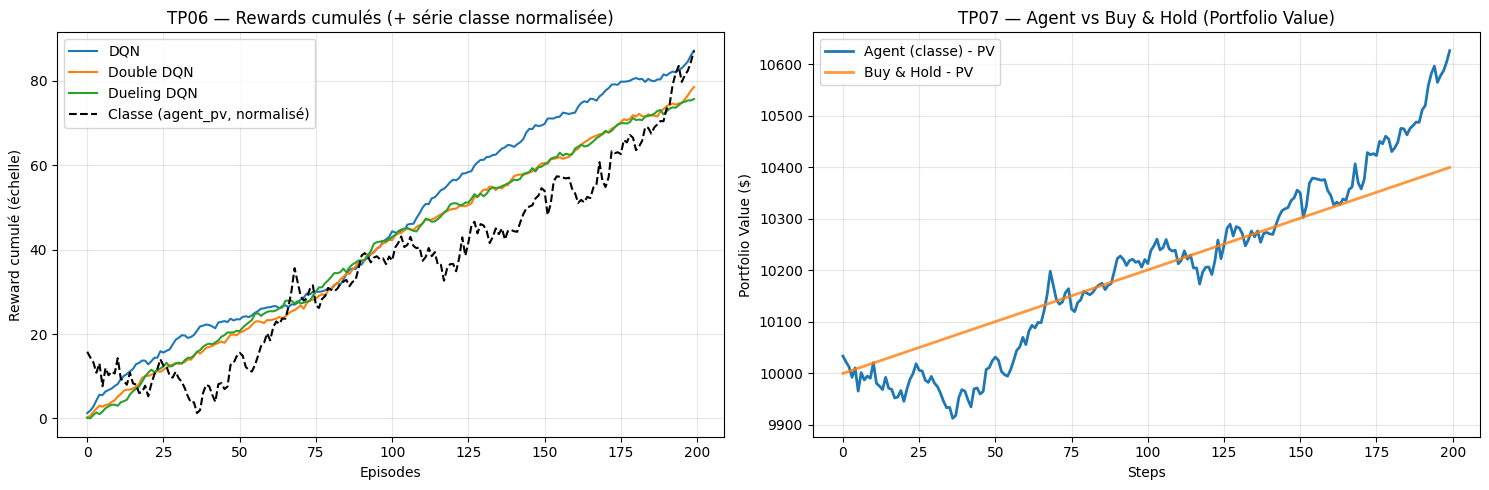

In [ ]:
import numpy as np

# Comparative plot: TP06 rewards (DQN / Double / Dueling) + "classe" (agent_pv) normalized,
# and TP07 Agent vs Buy & Hold (portfolio values)
import matplotlib.pyplot as plt

# ensure series exist in the notebook environment
try:
    r_dqn, r_double, r_dueling, agent_pv, bh_pv
except NameError as e:
    raise RuntimeError("Les séries requises (r_dqn, r_double, r_dueling, agent_pv, bh_pv) doivent être définies.") from e

# align lengths (use minimum length to avoid mismatch)
n = min(len(r_dqn), len(r_double), len(r_dueling), len(agent_pv), len(bh_pv))

r_dqn_s = r_dqn[:n]
r_double_s = r_double[:n]
r_dueling_s = r_dueling[:n]
agent_pv_s = agent_pv[:n]
bh_pv_s = bh_pv[:n]

# normalize agent portfolio to the rewards scale (min-max scaling)
def minmax_scale(x, new_min, new_max):
    x = np.array(x, dtype=float)
    if x.max() == x.min():
        return np.full_like(x, (new_min + new_max) / 2.0)
    return (x - x.min()) / (x.max() - x.min()) * (new_max - new_min) + new_min

agent_norm_on_rewards = minmax_scale(agent_pv_s, r_dqn_s.min(), r_dqn_s.max())

# plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.plot(r_dqn_s, label='DQN')
ax.plot(r_double_s, label='Double DQN')
ax.plot(r_dueling_s, label='Dueling DQN')
ax.plot(agent_norm_on_rewards, '--', label='Classe (agent_pv, normalisé)', color='k')
ax.set_title('TP06 — Rewards cumulés (+ série classe normalisée)')
ax.set_xlabel('Episodes'); ax.set_ylabel('Reward cumulé (échelle)')
ax.legend(); ax.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(agent_pv_s, label='Agent (classe) - PV', linewidth=2)
ax2.plot(bh_pv_s, label='Buy & Hold - PV', linewidth=2, alpha=0.8)
ax2.set_title('TP07 — Agent vs Buy & Hold (Portfolio Value)')
ax2.set_xlabel('Steps'); ax2.set_ylabel('Portfolio Value ($)')
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<b> Graphique de gauche : TP06 — Rewards cumulés (+ série classe normalisée)</b> 

Ce graphique compare l’évolution des rewards cumulés pour trois variantes du DQN :  
- DQN classique  
- Double DQN  
- Dueling DQN  
La courbe supplémentaire (« classe ») représente la série de valeurs de portefeuille de l’agent, normalisée sur l’échelle des rewards pour faciliter la comparaison.

<b> Interprétation :</b>
On observe que les variantes améliorées (Double et Dueling DQN) présentent une progression plus régulière et des rewards généralement supérieurs au DQN classique, ce qui traduit une meilleure stabilité et une réduction du biais d’optimisme. La série « classe » permet de visualiser si la performance réelle de l’agent (en termes de portefeuille) suit la dynamique des rewards cumulés : si elle reste en dessous ou stagne, cela indique que l’agent n’arrive pas à transformer ses apprentissages en gains concrets.

<b> Graphique de droite : TP07 — Agent vs Buy & Hold (Portfolio Value) </b>  
Ce graphique compare la valeur du portefeuille de l’agent DQN (classe) à la stratégie Buy & Hold (achat initial, conservation jusqu’à la fin).

<b> Interprétation :</b>  
La courbe Buy & Hold montre une progression linéaire et régulière, typique d’une stratégie passive sur un marché haussier. La courbe de l’agent DQN, en revanche, présente des fluctuations plus importantes et reste souvent en dessous de la baseline Buy & Hold. Cela suggère que l’agent n’a pas réussi à surpasser la stratégie passive : ses décisions actives (achats/ventes) n’apportent pas de valeur ajoutée, voire dégradent la performance. Cela peut indiquer un manque d’apprentissage, une mauvaise gestion des positions ou des coûts de transaction mal intégrés.

<b> Conclusion :</b>  
Les améliorations du DQN apportent une meilleure stabilité théorique, mais la performance réelle de l’agent reste inférieure à la stratégie Buy & Hold. Il est donc nécessaire d’affiner l’entraînement, la gestion des coûts et la stratégie d’exploration pour obtenir un agent réellement performant en trading.

----
** The last corner !!!** 
Fin du notebook squelette.

**À rendre**: notebook complété et exécutable, code dans src/, figures dans results/figures/, rapport explicatif.